OpenAlex
========

Today we will touch on programming with classes in Python and Jupyter. Classes allow you to "encapsulate" data and methods. We will also learn about rich outputs in Jupyter notebooks.

IF you are not familiar with classes in Python you should review them. Here are some reasonable introductions:

- https://towardsdatascience.com/introduction-to-python-classes-da526ff745df
- https://python.plainenglish.io/python-classes-and-objects-a13edcd2bc1e
- https://docs.python.org/3/tutorial/classes.html



# Introduction Python Classes

I will assume you have some experience with classes, and only introduce what we need for this lecture as we go.  We are going to create a single class today to represent a `Works` object. The class will get data for a doi, and provide some representations and methods that are convenient.

https://api.openalex.org/works/https://doi.org/10.1021/acscatal.5b00538



In [1]:
import requests

class Works:
    def __init__(self, oaid):
        self.oaid = oaid
        self.req = requests.get(f'https://api.openalex.org/works/{oaid}')
        self.data = self.req.json()
        
w = Works('https://doi.org/10.1021/acscatal.5b00538')



We can see that we saved attributes on our object, and we can access them.



In [2]:
w.oaid



'https://doi.org/10.1021/acscatal.5b00538'

In [3]:
w.req



<Response [200]>

In [8]:
w.data



{'id': 'https://openalex.org/W2288114809',
 'doi': 'https://doi.org/10.1021/acscatal.5b00538',
 'title': 'Examples of Effective Data Sharing in Scientific Publishing',
 'display_name': 'Examples of Effective Data Sharing in Scientific Publishing',
 'publication_year': 2015,
 'publication_date': '2015-05-29',
 'ids': {'openalex': 'https://openalex.org/W2288114809',
  'doi': 'https://doi.org/10.1021/acscatal.5b00538',
  'mag': '2288114809'},
 'primary_location': {'is_oa': True,
  'landing_page_url': 'https://doi.org/10.1021/acscatal.5b00538',
  'pdf_url': None,
  'source': {'id': 'https://openalex.org/S37391459',
   'display_name': 'ACS Catalysis',
   'issn_l': '2155-5435',
   'issn': ['2155-5435'],
   'host_organization': 'https://openalex.org/P4310320006',
   'host_organization_name': 'American Chemical Society',
   'type': 'journal'},
  'license': 'acs-specific: authorchoice/editors choice usage agreement',
  'version': 'publishedVersion'},
 'host_venue': {'id': 'https://openalex.org/

The object itself doesn't show us anything especially useful though:



In [11]:
w



## Python class representations

That is not a particularly helpful output. Let's see what we can do about it. There are two dunder methods that "present" an object: `__str__` and `__repr__`. The first is called when you print an object, and the second is the "representation" of the object.



In [12]:
class Works:
    def __init__(self, oaid):
        self.oaid = oaid
        self.req = requests.get(f'https://api.openalex.org/works/{oaid}')
        self.data = self.req.json()
        
    def __str__(self):
        return 'str'
        
    def __repr__(self):
        return 'repr'
        
w = Works('https://doi.org/10.1021/acscatal.5b00538')
print('print: ', w)
w



print:  str


repr

We probably want some basic information about the work. Let's construct a function that prints basic bibliographic information. We want a string in the form of:

authors, title, journal, volume/issue, pages, year, doi. cited by: count. open alex url

We can get all that from the json data.



In [18]:
class Works:
    def __init__(self, oaid):
        self.oaid = oaid
        self.req = requests.get(f'https://api.openalex.org/works/{oaid}')
        self.data = self.req.json()
        
    def __str__(self):
        return self.__repr__()
        
    def __repr__(self):
        _authors = [au['author']['display_name'] for au in self.data['authorships']]
        if len(_authors) == 1:
            authors = _authors[0]
        else:
            authors = ', '.join(_authors[0:-1]) + ' and ' + _authors[-1]
            
        title = self.data['title']
        
        journal = self.data['host_venue']['display_name']
        volume = self.data['biblio']['volume']
        
        issue = self.data['biblio']['issue']

            
        pages = '-'.join([self.data['biblio']['first_page'], self.data['biblio']['last_page']])
        year = self.data['publication_year']
        citedby = self.data['cited_by_count']
        
        oa = self.data['id']
        s = f'{authors}, {title}, {journal}, {volume}, {issue}, {pages}, ({year}), {self.data["doi"]}. cited by: {citedby}. {oa}'
        return s
    
w = Works('https://doi.org/10.1021/acscatal.5b00538')
print(w)
w


John R. Kitchin, Examples of Effective Data Sharing in Scientific Publishing, ACS Catalysis, 5, 6, 3894-3899, (2015), https://doi.org/10.1021/acscatal.5b00538. cited by: 18. https://openalex.org/W2288114809


John R. Kitchin, Examples of Effective Data Sharing in Scientific Publishing, ACS Catalysis, 5, 6, 3894-3899, (2015), https://doi.org/10.1021/acscatal.5b00538. cited by: 18. https://openalex.org/W2288114809

## Fancier representation in Markdown
That is pretty good but let's make it a little prettier. We can use markdown (or html) in this output. We simply define a new special function `_repr_markdown_`, which has precedence over `__repr__`, so it will be called by default here. Let's also add some functionality to the display. We can link each author to their OpenAlex page. Finally, we will provide a graph of citations by year.

We do this via markdown.



[John R. Kitchin](https://openalex.org/A4330425867), *Examples of Effective Data Sharing in Scientific Publishing*, **[ACS Catalysis](https://openalex.org/S37391459)**, 5, 63894-3899, (2015), https://doi.org/10.1021/acscatal.5b00538. cited by: 18. [Open Alex](https://openalex.org/W2288114809)<br>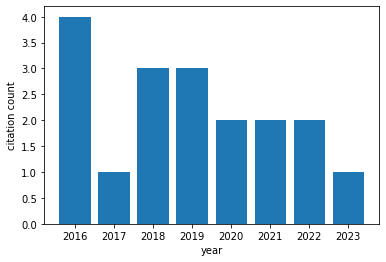

In [22]:
import base64
import matplotlib.pyplot as plt
from IPython.core.pylabtools import print_figure
    
class Works:
    def __init__(self, oaid):
        self.oaid = oaid
        self.req = requests.get(f'https://api.openalex.org/works/{oaid}')
        self.data = self.req.json()
        
    def __str__(self):
        return 'str'
        
    def __repr__(self):
        _authors = [au['author']['display_name'] for au in self.data['authorships']]
        if len(_authors) == 1:
            authors = _authors[0]
        else:
            authors = ', '.join(_authors[0:-1]) + ' and' + _authors[-1]
            
        title = self.data['title']
        
        journal = self.data['host_venue']['display_name']
        volume = self.data['biblio']['volume']
        
        issue = self.data['biblio']['issue']
        if issue is None:
            issue = ', '
        else:
            issue = ', ' + issue
            
        pages = '-'.join([self.data['biblio']['first_page'], self.data['biblio']['last_page']])
        year = self.data['publication_year']
        citedby = self.data['cited_by_count']
        
        oa = self.data['id']
        s = f'{authors}, {title}, {volume}{issue}{pages}, ({year}), {self.data["doi"]}. cited by: {citedby}. {oa}'
        return s
    
    def _repr_markdown_(self):
        _authors = [f'[{au["author"]["display_name"]}]({au["author"]["id"]})' for au in self.data['authorships']]
        if len(_authors) == 1:
            authors = _authors[0]
        else:
            authors = ', '.join(_authors[0:-1]) + ' and ' + _authors[-1]
            
        title = self.data['title']
        
        journal = f"[{self.data['host_venue']['display_name']}]({self.data['host_venue']['id']})"
        volume = self.data['biblio']['volume']
        
        issue = self.data['biblio']['issue']
        if issue is None:
            issue = ', '
        else:
            issue = ', ' + issue
            
        pages = '-'.join([self.data['biblio']['first_page'], self.data['biblio']['last_page']])
        year = self.data['publication_year']
        citedby = self.data['cited_by_count']
        
        oa = self.data['id']
        
        # Citation counts by year
        years = [e['year'] for e in self.data['counts_by_year']]
        counts = [e['cited_by_count'] for e in self.data['counts_by_year']]
    
        fig, ax = plt.subplots()
        ax.bar(years, counts)
        ax.set_xlabel('year')
        ax.set_ylabel('citation count')
        data = print_figure(fig, 'png') # save figure in string
        plt.close(fig)
        
        b64 = base64.b64encode(data).decode('utf8')
        citefig = (f'![img](data:image/png;base64,{b64})')
        
        s = f'{authors}, *{title}*, **{journal}**, {volume}{issue}{pages}, ({year}), {self.data["doi"]}. cited by: {citedby}. [Open Alex]({oa})'
        
        s += '<br>' + citefig
        return s
  
w = Works('https://doi.org/10.1021/acscatal.5b00538')
w



## A Class property to get an RIS entry

That looks pretty reasonable. Next, we might like to generate a bibliography entry, e.g. in bibtex or RIS form. bibtex can be used with LaTeX, and both can be imported into your favorite bibliographic tool, e.g. Zotero. Let's do [RIS](https://en.wikipedia.org/wiki/RIS_(file_format)).

The code here is not complete, and is only lightly tested so far. It isn't possible to know in advance all the variations of data we might come across, and we do not make the code too defensive at this stage.



In [ ]:
class Works:
    def __init__(self, oaid):
        self.oaid = oaid
        self.req = requests.get(f'https://api.openalex.org/works/{oaid}')
        self.data = self.req.json()
        
    def __str__(self):
        return 'str'
        
    def __repr__(self):
        _authors = [au['author']['display_name'] for au in self.data['authorships']]
        if len(_authors) == 1:
            authors = _authors[0]
        else:
            authors = ', '.join(_authors[0:-1]) + ' and' + _authors[-1]
            
        title = self.data['title']
        
        journal = self.data['host_venue']['display_name']
        volume = self.data['biblio']['volume']
        
        issue = self.data['biblio']['issue']
        if issue is None:
            issue = ', '
        else:
            issue = ', ' + issue
            
        pages = '-'.join([self.data['biblio']['first_page'], self.data['biblio']['last_page']])
        year = self.data['publication_year']
        citedby = self.data['cited_by_count']
        
        oa = self.data['id']
        s = f'{authors}, {title}, {volume}{issue}{pages}, ({year}), {self.data["doi"]}. cited by: {citedby}. {oa}'
        return s
    
    def _repr_markdown_(self):
        _authors = [f'[{au["author"]["display_name"]}]({au["author"]["id"]})' for au in self.data['authorships']]
        if len(_authors) == 1:
            authors = _authors[0]
        else:
            authors = ', '.join(_authors[0:-1]) + ' and ' + _authors[-1]
            
        title = self.data['title']
        
        journal = f"[{self.data['host_venue']['display_name']}]({self.data['host_venue']['id']})"
        volume = self.data['biblio']['volume']
        
        issue = self.data['biblio']['issue']
        if issue is None:
            issue = ', '
        else:
            issue = ', ' + issue
            
        pages = '-'.join([self.data['biblio']['first_page'], self.data['biblio']['last_page']])
        year = self.data['publication_year']
        citedby = self.data['cited_by_count']
        
        oa = self.data['id']
        
        # Citation counts by year
        years = [e['year'] for e in self.data['counts_by_year']]
        counts = [e['cited_by_count'] for e in self.data['counts_by_year']]
    
        fig, ax = plt.subplots()
        ax.bar(years, counts)
        ax.set_xlabel('year')
        ax.set_ylabel('citation count')
        data = print_figure(fig, 'png') # save figure in string
        plt.close(fig)
        
        b64 = base64.b64encode(data).decode('utf8')
        citefig = (f'![img](data:image/png;base64,{b64})')
        
        s = f'{authors}, *{title}*, **{journal}**, {volume}{issue}{pages}, ({year}), {self.data["doi"]}. cited by: {citedby}. [Open Alex]({oa})'
        
        s += '<br>' + citefig
        return s
    
    @property
    def ris(self):
        fields = []
        if self.data['type'] == 'journal-article':
            fields += ['TY  - JOUR']
        else:
            raise Exception("Unsupported type {self.data['type']}")
        
        for author in self.data['authorships']:
            fields += [f'AU  - {author["author"]["display_name"]}']
            
        fields += [f'PY  - {self.data["publication_year"]}']
        fields += [f'TI  - {self.data["title"]}']
        fields += [f'JO  - {self.data["host_venue"]["display_name"]}']
        fields += [f'VL  - {self.data["biblio"]["volume"]}']
        
        if self.data['biblio']['issue']:
            fields += [f'IS  - {self.data["biblio"]["issue"]}']
        
        
        fields += [f'SP  - {self.data["biblio"]["first_page"]}']
        fields += [f'EP  - {self.data["biblio"]["last_page"]}']
        fields += [f'DO  - {self.data["doi"]}']
        fields += ['ER  -']
                
        ris = '\n'.join(fields)
        ris64 = base64.b64encode(ris.encode('utf-8')).decode('utf8')
        uri = f'<pre>{ris}<pre><br><a href="data:text/plain;base64,{ris64}" download="ris">Download RIS</a>'
        from IPython.display import HTML
        return HTML(uri)
        
w = Works('https://doi.org/10.1021/acscatal.5b00538')
w.ris



You can copy that text to your clipboard, and import it to Zotero now. Or click on the link to download a file to your computer. Pretty sweet.



# Further enhancements

There are three additional things we might like for our Works class:

1. Get the references
2. Get citing works
3. Get related works

For each one of these, print out something useful. We start with related works. There is a limit of 10 requests per second, so we import time so we can add a short delay.



In [ ]:
import time

class Works:
    def __init__(self, oaid):
        self.oaid = oaid
        self.req = requests.get(f'https://api.openalex.org/works/{oaid}')
        self.data = self.req.json()
        
    def __str__(self):
        return 'str'
        
    def __repr__(self):
        _authors = [au['author']['display_name'] for au in self.data['authorships']]
        if len(_authors) == 1:
            authors = _authors[0]
        else:
            authors = ', '.join(_authors[0:-1]) + ' and' + _authors[-1]
            
        title = self.data['title']
        
        journal = self.data['host_venue']['display_name']
        volume = self.data['biblio']['volume']
        
        issue = self.data['biblio']['issue']
        if issue is None:
            issue = ', '
        else:
            issue = ', ' + issue

        pages = '-'.join([self.data['biblio'].get('first_page', '') or '',
                          self.data['biblio'].get('last_page', '') or ''])
        year = self.data['publication_year']
        citedby = self.data['cited_by_count']
        
        oa = self.data['id']
        s = f'{authors}, {title}, {volume}{issue}{pages}, ({year}), {self.data["doi"]}. cited by: {citedby}. {oa}'
        return s
    
    def _repr_markdown_(self):
        _authors = [f'[{au["author"]["display_name"]}]({au["author"]["id"]})' for au in self.data['authorships']]
        if len(_authors) == 1:
            authors = _authors[0]
        else:
            authors = ', '.join(_authors[0:-1]) + ' and ' + _authors[-1]
            
        title = self.data['title']
        
        journal = f"[{self.data['host_venue']['display_name']}]({self.data['host_venue']['id']})"
        volume = self.data['biblio']['volume']
        
        issue = self.data['biblio']['issue']
        if issue is None:
            issue = ', '
        else:
            issue = ', ' + issue
            
        pages = '-'.join([self.data['biblio'].get('first_page', '') or '',
                          self.data['biblio'].get('last_page', '') or ''])
        year = self.data['publication_year']
        citedby = self.data['cited_by_count']
        
        oa = self.data['id']
        
        # Citation counts by year
        years = [e['year'] for e in self.data['counts_by_year']]
        counts = [e['cited_by_count'] for e in self.data['counts_by_year']]
    
        fig, ax = plt.subplots()
        ax.bar(years, counts)
        ax.set_xlabel('year')
        ax.set_ylabel('citation count')
        data = print_figure(fig, 'png') # save figure in string
        plt.close(fig)
        
        b64 = base64.b64encode(data).decode('utf8')
        citefig = (f'![img](data:image/png;base64,{b64})')
        
        s = f'{authors}, *{title}*, **{journal}**, {volume}{issue}{pages}, ({year}), {self.data["doi"]}. cited by: {citedby}. [Open Alex]({oa})'
        
        s += '<br>' + citefig
        return s
    
    @property
    def ris(self):
        fields = []
        if self.data['type'] == 'journal-article':
            fields += ['TY  - JOUR']
        else:
            raise Exception("Unsupported type {self.data['type']}")
        
        for author in self.data['authorships']:
            fields += [f'AU  - {author["author"]["display_name"]}']
            
        fields += [f'PY  - {self.data["publication_year"]}']
        fields += [f'TI  - {self.data["title"]}']
        fields += [f'JO  - {self.data["host_venue"]["display_name"]}']
        fields += [f'VL  - {self.data["biblio"]["volume"]}']
        
        if self.data['biblio']['issue']:
            fields += [f'IS  - {self.data["biblio"]["issue"]}']
        
        
        fields += [f'SP  - {self.data["biblio"]["first_page"]}']
        fields += [f'EP  - {self.data["biblio"]["last_page"]}']
        fields += [f'DO  - {self.data["doi"]}']
        fields += ['ER  -']
                
        ris = '\n'.join(fields)
        ris64 = base64.b64encode(ris.encode('utf-8')).decode('utf8')
        uri = f'<pre>{ris}<pre><br><a href="data:text/plain;base64,{ris64}" download="ris">Download RIS</a>'
        from IPython.display import HTML
        return HTML(uri)
    
    def related_works(self):
        rworks = []
        for rw_url in self.data['related_works']:
            rw = Works(rw_url)
            rworks += [rw]
            time.sleep(0.101)
        return rworks
        

w = Works('https://doi.org/10.1021/acscatal.5b00538')
rw = w.related_works()
rw



Now, we can get the RIS for one of these.



In [ ]:
rw[2].ris



# Summary

Today we only reviewed Python classes, and worked out some ways to use a class to encapsulate information about a Works. The class is still incomplete in many ways.

1. It only exists in this notebook. Eventually, we will have to extract it into a file, and in a package.
2. It is not very fault tolerant. For example, it will give errors if any retrieved entry is not a journal article.
3. We did not implement all the features we desired.



# Exercise
If we have time, start working on the homework assignment.

